In [1]:
from optparse import OptionParser
import json
import os
import pickle
import random
import re
import pandas as pd
import pysam
import h5py
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("/home1/smaruj/akitaX1-analyses/figures/plot_styles/global_plotting_style.mplstyle")

In [3]:
# import tensorrt as trt (if installed, it's not used by Akita anyways)
import tensorflow as tf
from basenji import seqnn, stream

2024-06-24 15:22:00.542357: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 15:22:00.542404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 15:22:00.543262: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-24 15:22:00.548889: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 15:22:01.228543: W tensorflow/compiler/tf2

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU

In [5]:
print(tf.config.list_physical_devices('GPU'))

[]


In [6]:
from akita_utils.dna_utils import dna_1hot

from akita_utils.seq_gens import (
    symmertic_insertion_seqs_gen,
    reference_seqs_gen,
)

from akita_utils.tsv_gen_utils import (
    add_orientation,
    add_background,
    add_const_flank_and_diff_spacer,
)

In [7]:
# arguments 

genome_fasta = "/project/fudenber_735/genomes/mm10/mm10.fa" 
# out_dir = "./OUT"
stats = "SCD,INS-16,INS-64"
# stats = "SCD"
# batch_size=8 
batch_size=20
head_index = 1
model_index = 1
shifts = "0"
rc = False
background_file = f"/project/fudenber_735/akitaX1_analyses_data/background_generation/background_generation/background_sequences_model_{model_index}.fa"

In [8]:
CTCT_table = "./example_insertion_scores.tsv"

In [9]:
shifts = [int(shift) for shift in shifts.split(",")]
stats = stats.split(",")

In [10]:
models_dir="/project/fudenber_735/tensorflow_models/akita/v2/models"

In [11]:
params_file = models_dir + f"/f{model_index}c0" + "/train" + "/params.json"

In [12]:
params_file

'/project/fudenber_735/tensorflow_models/akita/v2/models/f1c0/train/params.json'

In [13]:
model_file = models_dir + f"/f{model_index}c0" + "/train" + f"/model{head_index}_best.h5"

In [14]:
model_file

'/project/fudenber_735/tensorflow_models/akita/v2/models/f1c0/train/model1_best.h5'

In [15]:
# read model parameters
with open(params_file) as params_open:
    params = json.load(params_open)
params_train = params["train"]
params_model = params["model"]

if batch_size is None:
    batch_size = params_train["batch_size"]
else:
    batch_size = batch_size

In [16]:
# load model
seqnn_model = seqnn.SeqNN(params_model)
seqnn_model.restore(model_file, head_i=head_index)
seqnn_model.build_ensemble(rc, shifts)
seq_length = int(params_model["seq_length"])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 1310720, 4)]         0         []                            
                                                                                                  
 stochastic_reverse_complem  ((None, 1310720, 4),         0         ['sequence[0][0]']            
 ent (StochasticReverseComp   ())                                                                 
 lement)                                                                                          
                                                                                                  
 stochastic_shift (Stochast  (None, 1310720, 4)           0         ['stochastic_reverse_complemen
 icShift)                                                           t[0][0]']               

In [17]:
# open genome FASTA
genome_open = pysam.Fastafile(genome_fasta)

In [18]:
seq_coords_df = pd.read_csv(CTCT_table, sep="\t")

In [19]:
seq_coords_df = seq_coords_df[["chrom", "end", "start", "strand"]]

In [20]:
seq_coords_df = seq_coords_df.copy()
seq_coords_df["seq_index"] = [i for i in range(len(seq_coords_df))]

In [21]:
seq_coords_df = add_orientation(seq_coords_df, orientation_strings=[">"], all_permutations=False)

In [22]:
seq_coords_df = add_background(seq_coords_df, background_indices_list=[0])

In [23]:
seq_coords_df = add_const_flank_and_diff_spacer(seq_coords_df, flank=30, spacing_list=[60])

In [24]:
background_seqs = []
    
with open(background_file, "r") as f:
    for line in f.readlines():
        if ">" in line:
            continue
        background_seqs.append(dna_1hot(line.strip()))


In [25]:
#################################################################
# predictions for references
backgrounds_predictions = seqnn_model.predict(np.array(background_seqs), batch_size=batch_size)

1/1 [==============================] - 8s 8s/step


In [26]:
preds_stream = stream.PredStreamGen(
        seqnn_model,
        symmertic_insertion_seqs_gen(seq_coords_df, background_seqs, genome_open),
        batch_size,
    )

In [27]:
num_experiments = len(seq_coords_df)

In [28]:
stats

['SCD', 'INS-16', 'INS-64']

In [29]:
from akita_utils.stats_utils import plot_map

In [30]:
from akita_utils.utils import ut_dense

In [31]:
from akita_utils.stats_utils import calculate_SCD

In [32]:
target_index = 0

1/1 [==============================] - 7s 7s/step


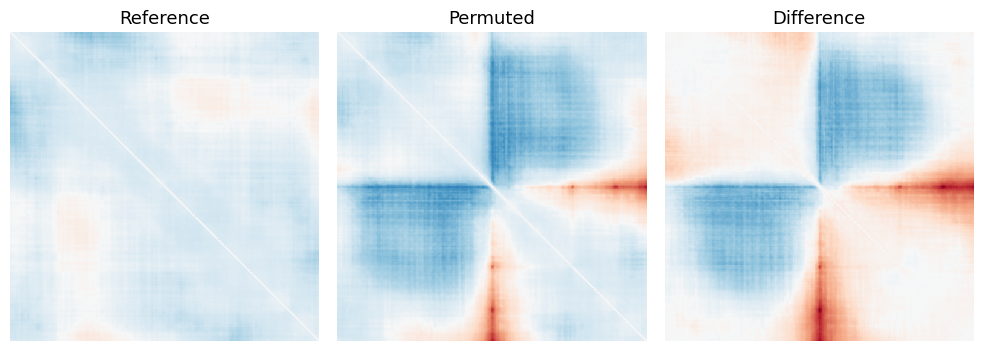

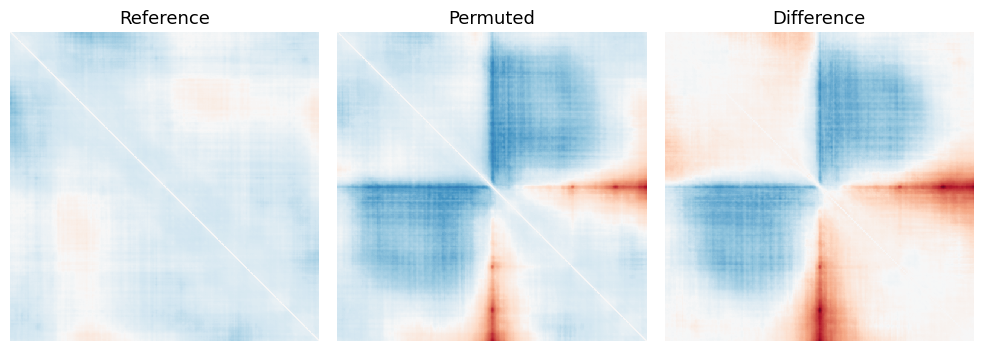

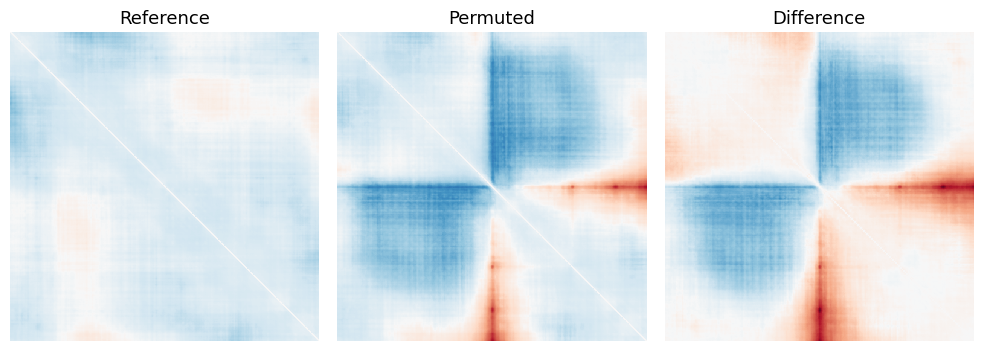

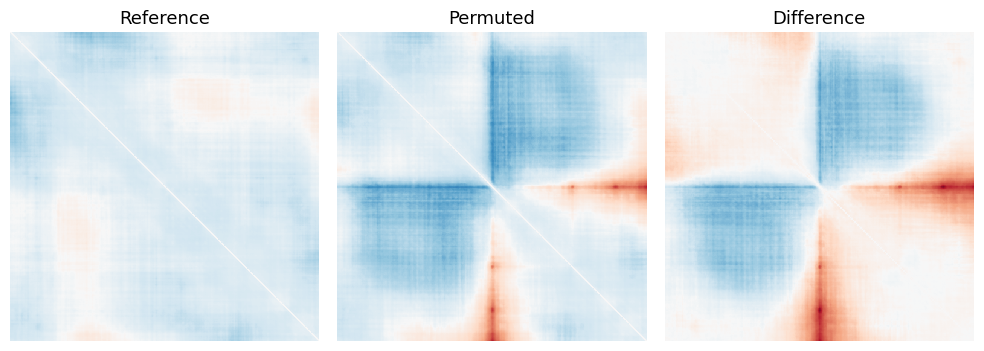

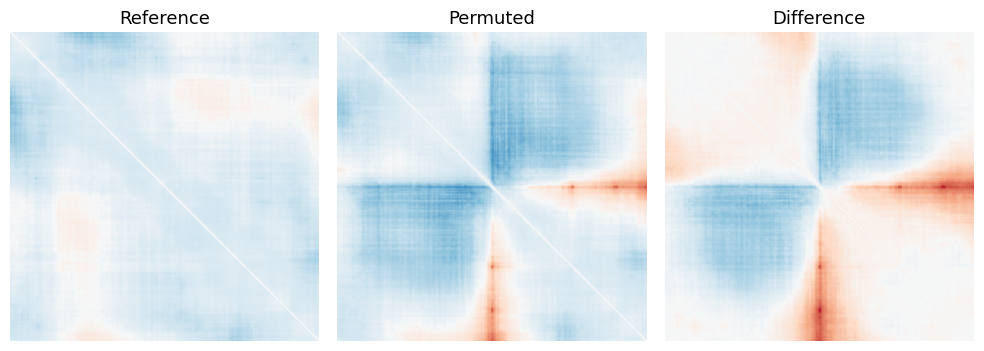

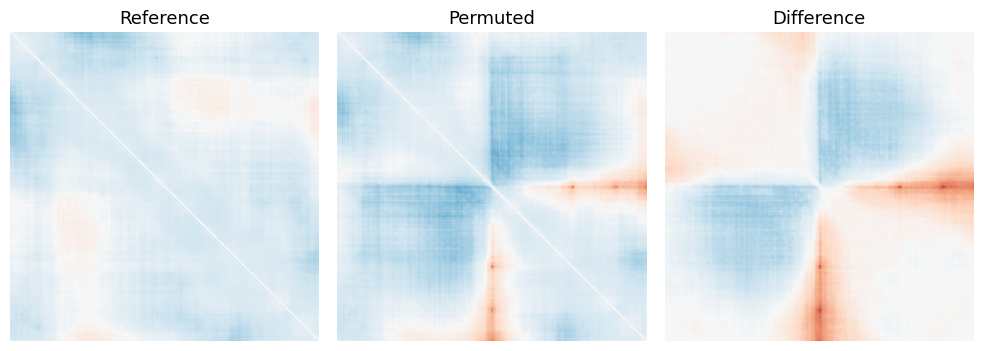

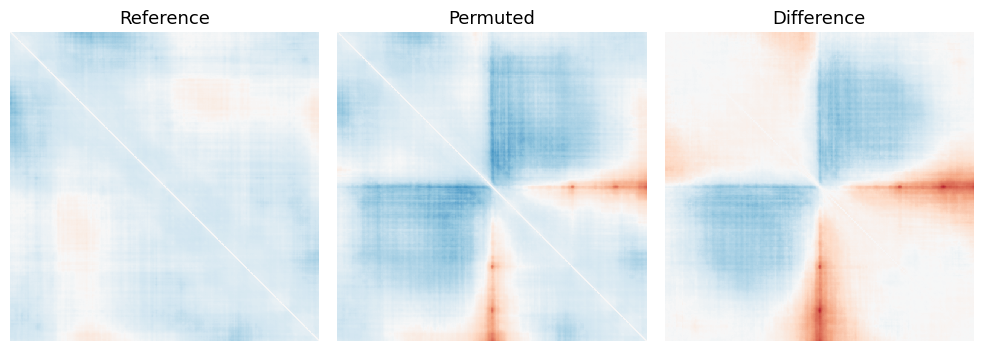

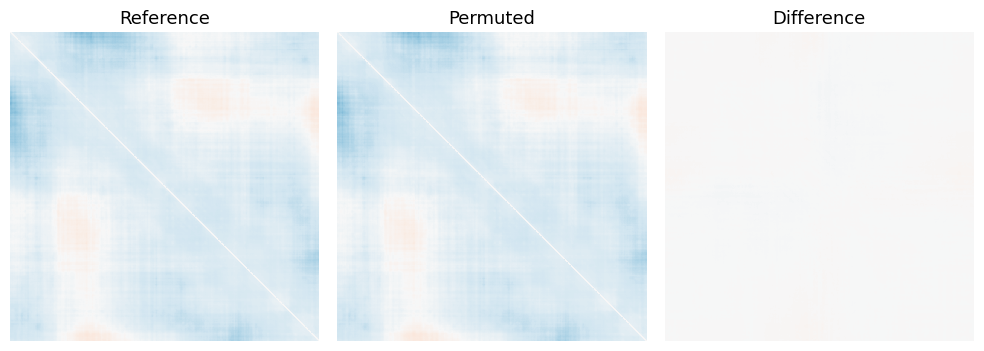

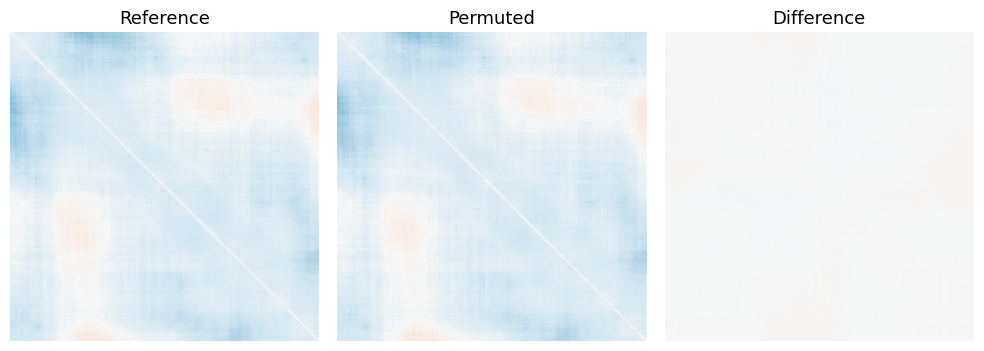

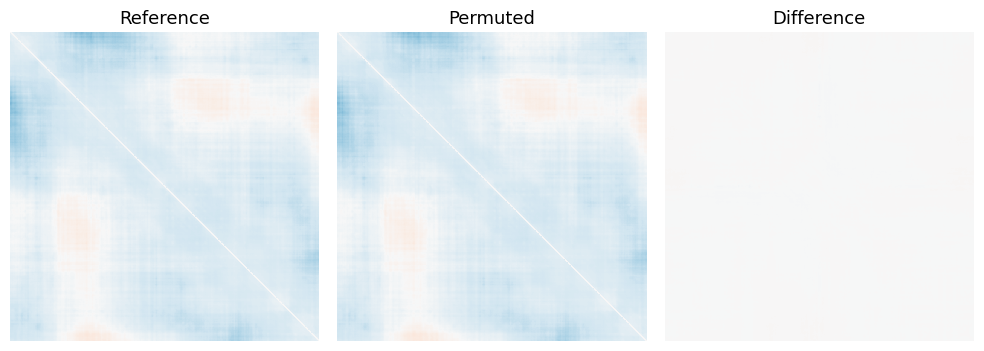

In [33]:
for exp_index in range(num_experiments):
    
    bg_index = seq_coords_df.iloc[exp_index].background_index

    prediction_matrix = preds_stream[exp_index]
    reference_prediction_matrix = backgrounds_predictions[bg_index, :, :]

    ref_maps = ut_dense(reference_prediction_matrix)
    alt_maps = ut_dense(prediction_matrix)

    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    sns.heatmap(
        ref_maps[:,:,target_index],
        vmin=-0.6,
        vmax=0.6,
        cbar=False,
        cmap="RdBu_r",
        square=True,
        xticklabels=False,
        yticklabels=False,
        ax=axs[0]
    )
    axs[0].set_title('Reference')
    
    sns.heatmap(
        alt_maps[:,:,target_index],
        vmin=-0.6,
        vmax=0.6,
        cbar=False,
        cmap="RdBu_r",
        square=True,
        xticklabels=False,
        yticklabels=False,
        ax=axs[1]
    )
    axs[1].set_title('Permuted')

    sns.heatmap(
        alt_maps[:,:,target_index]-ref_maps[:,:,target_index],
        vmin=-0.6,
        vmax=0.6,
        cbar=False,
        cmap="RdBu_r",
        square=True,
        xticklabels=False,
        yticklabels=False,
        ax=axs[2]
    )
    axs[2].set_title('Difference')
    
    plt.tight_layout()
    plt.show()

In [34]:
genome_open.close()